In [1]:
!pip install dagster dagster-webserver yfinance scikit-learn matplotlib seaborn pandas


In [2]:
import time
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dagster import asset, Definitions
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [3]:
@asset
def raw_data():
    start = time.time()
    df = yf.download("AAPL", start="2022-01-01", end="2024-01-01")
    print("Data load time:", round(time.time() - start, 2), "seconds")
    return df


In [4]:
@asset
def eda(raw_data):
    df = raw_data.copy()

    # 1. Closing Price Trend
    plt.figure()
    df["Close"].plot(title="Closing Price Trend")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

    # 2. Volume Chart
    plt.figure()
    df["Volume"].plot(title="Trading Volume")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.show()

    # 3. Daily Returns Histogram
    returns = df["Close"].pct_change()
    plt.figure()
    sns.histplot(returns.dropna(), bins=40)
    plt.title("Daily Return Distribution")
    plt.xlabel("Return")
    plt.show()

    # 4. Correlation Heatmap
    plt.figure()
    sns.heatmap(
        df[["Open", "High", "Low", "Close", "Volume"]].corr(),
        annot=True,
        cmap="coolwarm"
    )
    plt.title("Feature Correlation Heatmap")
    plt.show()

    return "EDA Completed"


In [5]:
@asset
def dataset(raw_data):
    df = raw_data.copy()
    df["Return"] = df["Close"].pct_change()
    df["RollingMean"] = df["Close"].rolling(5).mean()
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    return df.dropna()


In [6]:
@asset
def train_test(dataset):
    X = dataset[["Return", "RollingMean"]]
    y = dataset["Target"]
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
@asset
def decision_tree(train_test):
    start = time.time()
    X_train, X_test, y_train, y_test = train_test

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))

    print("Decision Tree Accuracy:", round(acc, 3))
    print("Execution Time:", round(time.time() - start, 2), "seconds")
    return acc


In [9]:
@asset
def logistic_regression(train_test):
    start = time.time()
    X_train, X_test, y_train, y_test = train_test

    model = LogisticRegression()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))

    print("Logistic Regression Accuracy:", round(acc, 3))
    print("Execution Time:", round(time.time() - start, 2), "seconds")
    return acc


In [10]:
@asset
def random_forest(train_test):
    start = time.time()
    X_train, X_test, y_train, y_test = train_test

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))

    print("Random Forest Accuracy:", round(acc, 3))
    print("Execution Time:", round(time.time() - start, 2), "seconds")
    return acc


In [11]:
@asset
def model_comparison(decision_tree, logistic_regression, random_forest):
    models = ["Decision Tree", "Logistic Regression", "Random Forest"]
    scores = [decision_tree, logistic_regression, random_forest]

    plt.figure()
    plt.bar(models, scores)
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

    return dict(zip(models, scores))


In [15]:
import time
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

start_time = time.time()

df = yf.download("AAPL", start="2022-01-01", end="2024-01-01")

df["Return"] = df["Close"].pct_change()
df["RollingMean"] = df["Close"].rolling(5).mean()
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df = df.dropna()

X = df[["Return", "RollingMean"]]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

DecisionTreeClassifier().fit(X_train, y_train)
LogisticRegression().fit(X_train, y_train)
RandomForestClassifier().fit(X_train, y_train)

end_time = time.time()

print("WITHOUT Dagster execution time:", round(end_time - start_time, 2), "seconds")


/tmp/ipython-input-918473701.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2022-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


WITHOUT Dagster execution time: 1.0 seconds


2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - RUN_START - Started execution of run for "__ephemeral_asset_job__".
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - ENGINE_EVENT - Executing steps in process (pid: 958)
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - LOGS_CAPTURED - Started capturing logs in process (pid: 958).
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1

Data load time: 0.14 seconds


2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - dataset - Writing file at: /tmp/tmpqoomvk1c/storage/dataset using PickledObjectFilesystemIOManager...
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - dataset - ASSET_MATERIALIZATION - Materialized value dataset.
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - dataset - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - dataset - STEP_SUCCESS - Finished execution of step "dataset" in 163ms.
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - eda - STEP_START - Started execution of step "eda".
2026-01-31 14:06:12 +0000 - dagster - DEBUG - __ephe

<Figure size 640x480 with 0 Axes>

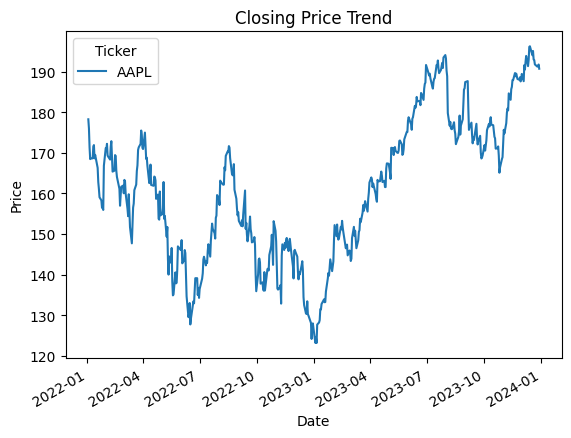

<Figure size 640x480 with 0 Axes>

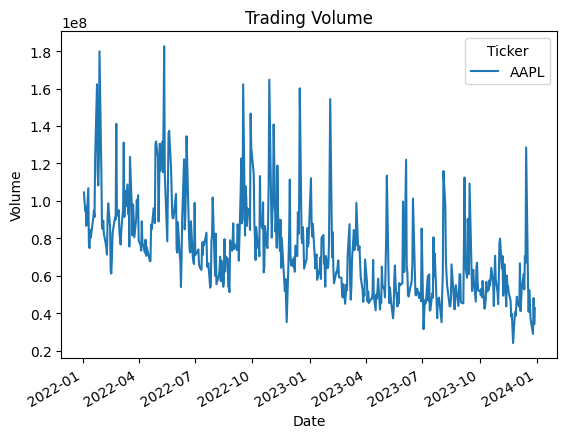

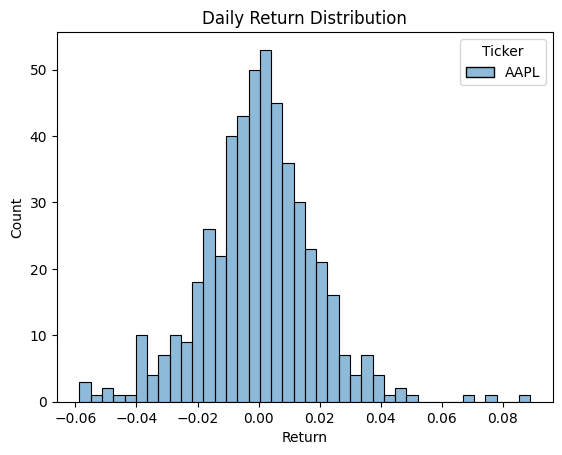

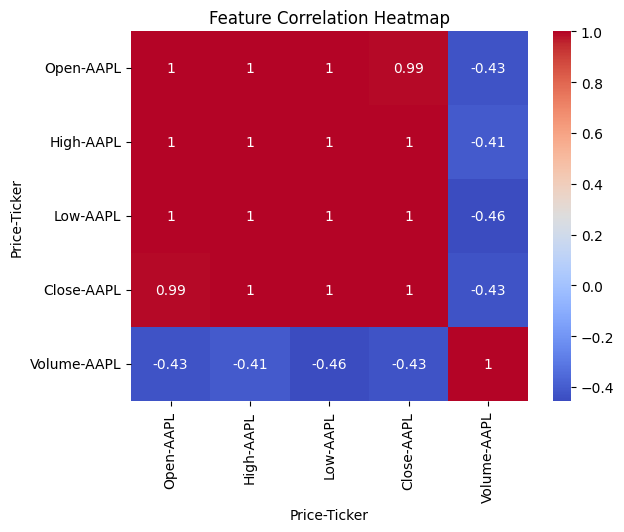

2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - eda - Writing file at: /tmp/tmpqoomvk1c/storage/eda using PickledObjectFilesystemIOManager...
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - eda - ASSET_MATERIALIZATION - Materialized value eda.
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - eda - STEP_SUCCESS - Finished execution of step "eda" in 2.65s.
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephe

Decision Tree Accuracy: 0.48
Execution Time: 0.02 seconds


2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - logistic_regression - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - logistic_regression - Writing file at: /tmp/tmpqoomvk1c/storage/logistic_regression using PickledObjectFilesystemIOManager...
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - logistic_regression - ASSET_MATERIALIZATION - Materialized value logistic_regression.
2026-01-31 14:06:15 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - logistic_regression - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - logistic_regression 

Logistic Regression Accuracy: 0.47
Execution Time: 0.25 seconds


2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - random_forest - LOADED_INPUT - Loaded input "train_test" using input manager "io_manager", from output "result" of step "train_test"
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - random_forest - STEP_INPUT - Got input "train_test" of type "Any". (Type check passed).
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - random_forest - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - random_forest - Writing file at: /tmp/tmpqoomvk1c/storage/random_forest using PickledObjectFilesystemIOManager...
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 95

Random Forest Accuracy: 0.48
Execution Time: 0.35 seconds


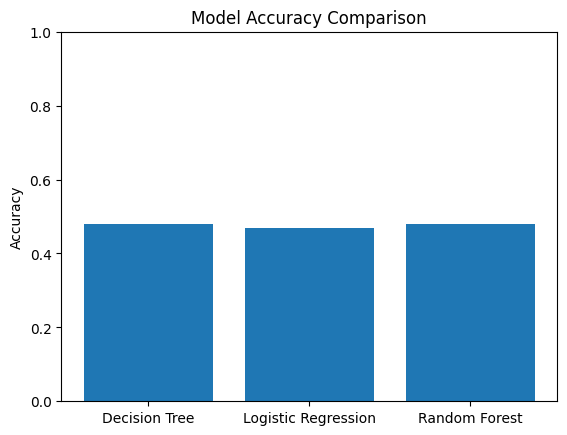

2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - model_comparison - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - model_comparison - Writing file at: /tmp/tmpqoomvk1c/storage/model_comparison using PickledObjectFilesystemIOManager...
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - model_comparison - ASSET_MATERIALIZATION - Materialized value model_comparison.
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - model_comparison - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-31 14:06:16 +0000 - dagster - DEBUG - __ephemeral_asset_job__ - 68e97e20-1d26-4285-8581-f4d9a8664374 - 958 - model_comparison - STEP_SUCCESS - Fini

WITH Dagster execution time: 4.83 seconds


In [16]:
import time
from dagster import materialize

start_time = time.time()

materialize([
    raw_data,
    eda,
    dataset,
    train_test,
    decision_tree,
    logistic_regression,
    random_forest,
    model_comparison
])

end_time = time.time()

print("WITH Dagster execution time:", round(end_time - start_time, 2), "seconds")
